<a href="https://colab.research.google.com/github/harnalashok/Clustering/blob/master/online_retail_rfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 14th April, 2021
# Ref: https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering
# My folder:
# github: harnalashok/clustering/
# 

### Transform data

#### Call libraries

In [134]:
# 1.0 Import required libraries for dataframe and visualization

import numpy as np
import pandas as pd

# 1.0.1 Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 1.0.2 import required libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1.0.3
import os
%matplotlib inline
from scipy import stats

In [135]:
# 1.1 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read and explore

In [136]:
# 1.1.2 My data folder
path = "/content" 
os.chdir(path)
os.listdir()

['.config', 'OnlineRetail.csv', 'sample_data']

In [137]:
# 1.2 Read Data
data = pd.read_csv(
                   "OnlineRetail.csv",
                   #"onlineretail.zip",
                   encoding = "ISO_8859_1",
                   engine = 'python', # Takes time but reads full file
                                      # 'c' engine is faster but has problems
                                      # at separators. Default is 'c'
                   header = 0
                   #parse_dates=True        # InvoiceDate does not get converted to date
                   )


In [138]:
# 1.2.1 
data.shape   # (541909, 8)
print()
data.dtypes  
print()
data.head()

(541909, 8)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [139]:
# 1.2.2 Transform InvoiceDate dtype to datetype
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
# 1.2.3 Examine data
print("\n-----InvoiceNo------\n")
data.InvoiceNo.value_counts()     # 25900 unique
print()
print("\n-----StockCode------\n")
data.StockCode.value_counts()     # 4070  unique
print()
print("\n----CustomerID-------\n")
data.CustomerID.value_counts()    # 4372 unique
print("\n----Country-------\n")
data.Country.value_counts()       # 38 unique
print()
len(data.Country.value_counts())  # 38 unique

In [141]:
# 1.2.4 Are there NAs?
data.isnull().sum()   # Yes, there are

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [142]:
# 1.3 Cleanup data. Remove those 
#     rows where no CustomerIDs

data = data[~data["CustomerID"].isnull()]
data.shape  # (406829, 8)

(406829, 8)

In [143]:
# 1.4 Checking for duplicates. Remove duplicates:

data = data[~data.duplicated()]
data.shape   # (401604, 8)  ; data.drop_duplicates(keep='first', inplace=True)

(401604, 8)

In [144]:
# 1.5 Let us see max and min dates:

data.sort_values(by = "InvoiceDate", ascending = False).head()
data.sort_values(by = "InvoiceDate",ascending = False).tail()

InvoiceNo StockCode  ... CustomerID         Country
394691    570876     23083  ...    16085.0  United Kingdom
394690    570876     22469  ...    16085.0  United Kingdom
394694    570876     23509  ...    16085.0  United Kingdom
394695    570876     23048  ...    16085.0  United Kingdom
394696    570876     23503  ...    16085.0  United Kingdom

[5 rows x 8 columns]

InvoiceNo StockCode  ... CustomerID         Country
3    536365    84029G  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
5    536365     22752  ...    17850.0  United Kingdom
6    536365     21730  ...    17850.0  United Kingdom
0    536365    85123A  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [145]:
# 1.6 Revenue generated, per row:

data['rev'] = data['UnitPrice'] * data['Quantity']

#### Univariate distributions
Plotting with [plotly express](https://plotly.com/python/plotly-express/)

In [146]:
# 2.0 Our data is huge. Sample it
small = data.sample(frac=0.1)
small.shape

(40160, 9)

In [14]:
# 2.1
# https://plotly.com/python/histograms/
# https://plotly.com/python/axes/
fig = px.histogram(small, x = "rev")
fig.update_xaxes(range=[0, 1000])

In [150]:
# 2.2
# https://plotly.com/python/box-plots/
fig = px.box(small, y='rev')
fig.show()

In [151]:
# 2.3 Country wise distribution
fig = px.box(small, x = 'Country',y='rev')
fig.show()

#### Extract data

##### Recency first
Takes time

In [152]:
# 2.0
df = data.copy()

In [153]:
# 2.1 
grd = df.groupby("CustomerID")

In [154]:
# 2.2 Create an empty dataframe
#     having same columns as the original:

df_recency = pd.DataFrame(columns = df.columns)
df_recency.head()

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, rev]
Index: []

In [155]:
# 2.3 For every group, customer-wise
#     get dataframe, sort is invoice-date wise
#     and pick up the last (most-recent date):

for i, d in grd:
  d = d.reset_index().sort_values(by = ['InvoiceDate'], ascending = False)
  df_recency = pd.concat([df_recency, d.head(1)])

In [156]:
# 2.3.1 Examine extracted information:

df_recency.shape     # (4372,10)
print()
df_recency.head()
print()
df_recency[['CustomerID', 'InvoiceDate']].head()
print()
df_recency['InvoiceDate'].min()
print()
df_recency['recency']= (df_recency['InvoiceDate'].max() - df_recency['InvoiceDate'])/ pd.Timedelta("1 days")
print()
df_recency = df_recency[['CustomerID', 'recency']]

(4372, 10)

InvoiceNo StockCode  ...      rev     index
1     C541433     23166  ... -77183.6   61624.0
145    573511     23508  ...      8.4  428978.0
30     568172      POST  ...     40.0  359060.0
0      577609     23112  ...     15.0  485502.0
0      543037     21908  ...     25.2   80323.0

[5 rows x 10 columns]

CustomerID         InvoiceDate
1       12346.0 2011-01-18 10:17:00
145     12347.0 2011-10-31 12:25:00
30      12348.0 2011-09-25 13:13:00
0       12349.0 2011-11-21 09:51:00
0       12350.0 2011-02-02 16:01:00

Timestamp('2010-01-12 09:53:00')

In [157]:
# 2.3.2
df_recency.head()
print()
df_recency.recency.min()  # 0.0

CustomerID     recency
1       12346.0  326.293056
145     12347.0   40.204167
30      12348.0   76.170833
0       12349.0   19.311111
0       12350.0  311.054167

0.0

#####Frequency next

In [158]:
# 3.0
grpd = df.groupby(['CustomerID'])

In [159]:
# 3.1 Frequency: How many unique invoice numbers exist
#                per customer

df_freq = grpd['InvoiceNo'].nunique().reset_index()
df_freq.columns = ['CustomerID', 'frequency']
df_freq.head()


CustomerID  frequency
0     12346.0          2
1     12347.0          7
2     12348.0          4
3     12349.0          1
4     12350.0          1

##### Revenue/customer

In [160]:
# 4.0
grpd = df.groupby('CustomerID')

In [161]:
# 4.1 Sum-up all purchases
df_rev = grpd['rev'].sum().reset_index()
df_rev.columns = ['CustomerID', 'revenue']
df_rev.head()

CustomerID  revenue
0     12346.0     0.00
1     12347.0  4310.00
2     12348.0  1797.24
3     12349.0  1757.55
4     12350.0   334.40

##### High avg price buyer?

In [ ]:
grpd = df.groupby('CustomerID')

In [256]:
# 4.1 Average unit-prices
df_up = grpd['UnitPrice'].mean().reset_index()
df_up.columns = ['CustomerID', 'avg_unitprice']
df_up.head()

CustomerID  avg_unitprice
0     12346.0       1.040000
1     12347.0       2.644011
2     12348.0       5.764839
3     12349.0       8.289041
4     12350.0       3.841176

##### Create rfm DataFrame now
Merge all datasets

In [257]:
# 5.0
rfm = df_rev.merge(df_recency)
rfm = rfm.merge(df_freq)
rfm = rfm.merge(df_up)
rfm.shape   # (4372, 5)
rfm.head()

(4372, 5)

CustomerID  revenue     recency  frequency  avg_unitprice
0     12346.0     0.00  326.293056          2       1.040000
1     12347.0  4310.00   40.204167          7       2.644011
2     12348.0  1797.24   76.170833          4       5.764839
3     12349.0  1757.55   19.311111          1       8.289041
4     12350.0   334.40  311.054167          1       3.841176

####Distributions  

#####Univariate

In [163]:
# 5.1
fig = px.histogram(rfm, x = "frequency")
fig.show()

In [164]:
# 5.2
fig = px.histogram(rfm, x = "recency")
fig.show()

In [165]:
# 5.3
fig = px.histogram(rfm, x = "revenue")
fig.show()

In [258]:
# 5.3.1
fig = px.histogram(rfm, x = "avg_unitprice")
fig.show()

#####Jointplots

In [66]:
# 5.4
fig = px.density_heatmap(
                         rfm,
                         x="frequency",
                         y="recency"
                         )

fig.update_xaxes(range=[0, 50])


In [74]:
# 5.5
fig = px.density_heatmap(
                         rfm,
                         x="frequency",
                         y="recency",
                         marginal_x="histogram"                        
                         )

fig.update_xaxes(range=[0, 25])

In [82]:
# 5.6
fig = px.density_contour(rfm, x="revenue", y="recency")
fig.update_xaxes(range=[0, 10000])

In [81]:
# 5.7
fig = px.density_contour(rfm, x="revenue", y="recency")
_=fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.update_xaxes(range=[0, 10000])

### Removing outliers
Before we cluster data:
>a. Remove outliers<br>
>b. Perform boxcox transformation to make relevant features symmteric

IQR

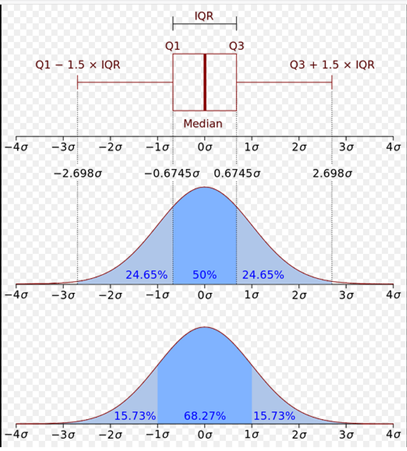



Quantile vs Quartile vs Percentile<br>
Refer [here](https://stats.stackexchange.com/a/156787)

> 0 quartile = 0 quantile = 0 percentile

> 1 quartile = 0.25 quantile = 25 percentile

> 2 quartile = .5 quantile = 50 percentile (median)

> 3 quartile = .75 quantile = 75 percentile

> 4 quartile = 1 quantile = 100 percentile


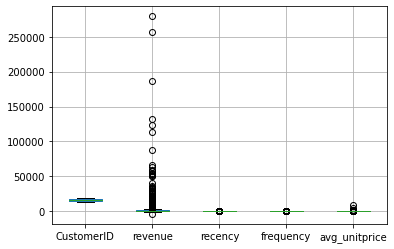

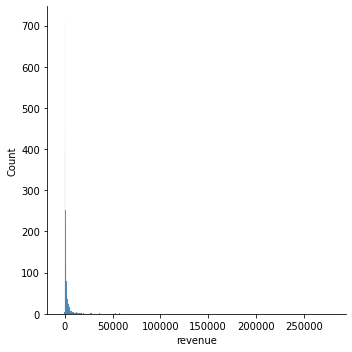

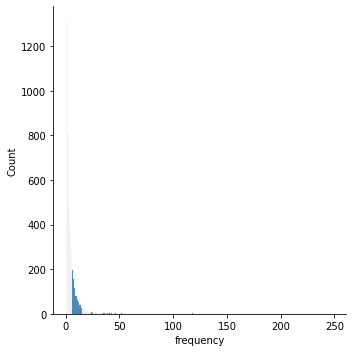

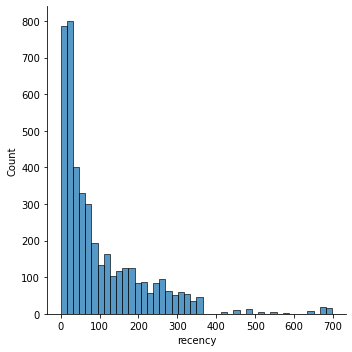

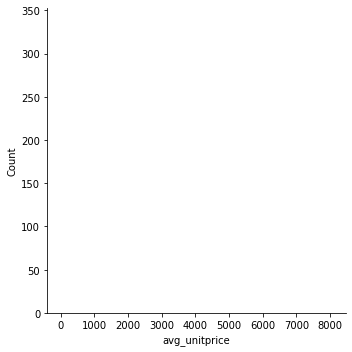

In [267]:
# 6.0 One way to look at outliers:

_=rfm.boxplot()
_=sns.displot(data = rfm, x = "revenue")
_=sns.displot(data = rfm, x = "frequency")
_=sns.displot(data = rfm, x = "recency")
_=sns.displot(data = rfm, x = "avg_unitprice")

In [263]:
# 6.0.1
cols = ["revenue", "frequency", "recency"]
cols1 = ["revenue", "frequency", "recency", "avg_unitprice"]

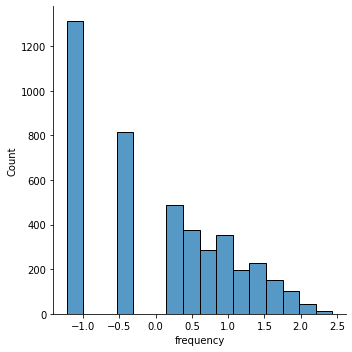

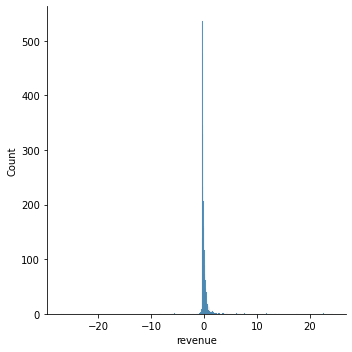

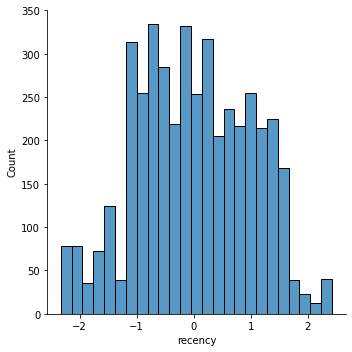

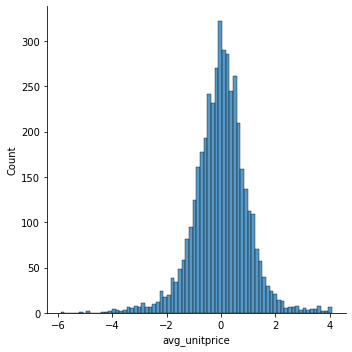

In [264]:
# 6.0.2
from sklearn.preprocessing import power_transform
rfm_boxcox = power_transform(rfm[cols1], method = 'yeo-johnson')
rfm_boxcox = pd.DataFrame(rfm_boxcox, columns=cols1)

_=sns.displot(rfm_boxcox, x = "frequency")
_=sns.displot(rfm_boxcox, x = "revenue")
_=sns.displot(rfm_boxcox, x = "recency")
_=sns.displot(rfm_boxcox, x = "avg_unitprice")

In [265]:
# 6.1 Calculate few stats:

cols = ["revenue", "frequency", "recency"]
print("\n\n----0.99 quantile-----\n")
rfm[cols].quantile(0.99)
print("\n\n----0.75 quantile-----\n")
rfm[cols].quantile(0.75)
print("\n\n----0.25 quantile-----\n")
rfm[cols].quantile(0.25)
print("\n\n----iqr-----\n")
iqr = rfm[cols].quantile(0.75) - rfm[cols].quantile(0.25)
print()
iqr  # rev: 1316, recency: 132,frequency: 4.0 



----0.99 quantile-----



revenue      17226.29490
frequency       36.00000
recency        546.22316
Name: 0.99, dtype: float64



----0.75 quantile-----



revenue      1608.335000
frequency       5.000000
recency       152.244965
Name: 0.75, dtype: float64



----0.25 quantile-----



revenue      291.795000
frequency      1.000000
recency       20.183681
Name: 0.25, dtype: float64



----iqr-----




revenue      1316.540000
frequency       4.000000
recency       132.061285
dtype: float64

In [268]:
# 6.2 Use scipy stats:

# 6.2.1 Calcluate IQR for each feature:
iqr_rev = stats.iqr(rfm.revenue, interpolation = 'midpoint')
iqr_recency = stats.iqr(rfm.recency, interpolation = 'midpoint')
iqr_freq = stats.iqr(rfm.frequency, interpolation = 'midpoint')

# 6.2.2
print()
print("iqr_rev:", iqr_rev)
print("iqr_recency: ", iqr_recency)
print("iqr_freq: ", iqr_freq)


iqr_rev: 1317.23
iqr_recency:  132.06631944444445
iqr_freq:  4.0


#### Using IQR to calculate outliers

#### Remove outlier function

In [269]:
# 6.3 Function removes outliers
def rem_outliers(feature, data):
  """
  Given a 'feature' and a DataFrame,
  this function removes rows with
  outliers in 'feature' and returns
  remaining DataFrame.
  """
  # 6.3.1
  q1 = data[feature].quantile(0.25)
  q3 = data[feature].quantile(0.75)
  iqr = q3-q1
  # 6.3.2
  upper_lt = q3 + iqr * 1.5
  lower_lt = q1 - iqr * 1.5
  # 6.3.3
  return data.loc[(data[feature] >lower_lt) & (data[feature] < upper_lt), : ] 

#### Remove outlier from 'frequency' feature

In [183]:
# 6.3.1
print(rem_outliers.__doc__)


  Given a 'feature' and a DataFrame,
  this function removes rows with
  outliers in 'feature' and returns
  remaining DataFrame.
  


In [270]:
# 7.0 Remove outliers from 'frequency' feature:
rfm_freq = rem_outliers('frequency', rfm) 
rfm_freq.shape    # (3913,4)
rfm_freq.head()


(3913, 5)

CustomerID  revenue     recency  frequency  avg_unitprice
0     12346.0     0.00  326.293056          2       1.040000
1     12347.0  4310.00   40.204167          7       2.644011
2     12348.0  1797.24   76.170833          4       5.764839
3     12349.0  1757.55   19.311111          1       8.289041
4     12350.0   334.40  311.054167          1       3.841176

In [271]:
# 7.1 Do outlier still remain in other
#     features also?

fig = px.histogram(rfm_freq, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_freq, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_freq, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

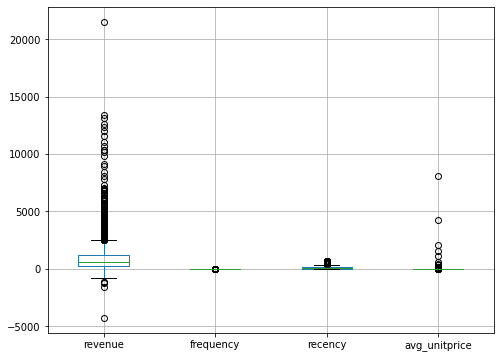

In [274]:
# 7.2 Look at boxplots also:
fig = plt.figure(figsize=(8,6))
_=rfm_freq[cols1].boxplot()

#### Remove outlier from 'recency' feature

In [275]:
# 7.3
rfm_recency = rem_outliers('recency', rfm) 

# 7.3.1
rfm_recency.shape    # (4244, 4)
rfm_recency.head()


(4244, 5)

CustomerID  revenue     recency  frequency  avg_unitprice
0     12346.0     0.00  326.293056          2       1.040000
1     12347.0  4310.00   40.204167          7       2.644011
2     12348.0  1797.24   76.170833          4       5.764839
3     12349.0  1757.55   19.311111          1       8.289041
4     12350.0   334.40  311.054167          1       3.841176

In [276]:
# 7.4 So after removal from 'recency'
#     let us look at outliers again

fig = px.histogram(rfm_recency, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_recency, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_recency, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

#### Remove outliers from 'revenue' feature

In [277]:
# 7.5
rfm_revenue = rem_outliers('revenue', rfm) 

# 7.5.1
rfm_revenue.shape    # (4244, 4)
rfm_revenue.head()


(3951, 5)

CustomerID  revenue     recency  frequency  avg_unitprice
0     12346.0     0.00  326.293056          2       1.040000
2     12348.0  1797.24   76.170833          4       5.764839
3     12349.0  1757.55   19.311111          1       8.289041
4     12350.0   334.40  311.054167          1       3.841176
5     12352.0  1545.41   73.097917         11      23.274737

In [278]:
# 7.5.2
fig = px.histogram(rfm_revenue, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_revenue, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_revenue, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

#### Remove both 'revenue' and 'frequency' outliers

In [279]:
# 7.6 Remove both 'revenue' and 'frequency' outliers
rfm_freq2 = rem_outliers('frequency', rfm_revenue) 
rfm_freq2.shape    # (4244, 4)
rfm_freq2.head()


(3663, 5)

CustomerID  revenue     recency  frequency  avg_unitprice
0     12346.0     0.00  326.293056          2       1.040000
2     12348.0  1797.24   76.170833          4       5.764839
3     12349.0  1757.55   19.311111          1       8.289041
4     12350.0   334.40  311.054167          1       3.841176
6     12353.0    89.00  204.980556          1       6.075000

In [280]:
# 7.5.3

fig = px.histogram(rfm_freq2, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_freq2, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_freq2, x = "revenue", width=600, height=400)

fig.show()
fig1.show()
fig2.show()

#### Another way to remove outliers
Look at 5th percentile and 95th percentile

In [281]:
#8.0 Another way

#8.1  Removing (statistical) outliers for revenue
lower_rev = rfm.revenue.quantile(0.05)
upper_rev = rfm.revenue.quantile(0.95)
rfm_aw = rfm[(rfm.revenue >= lower_rev) & (rfm.revenue <= upper_rev)]

#8.2 Removing (statistical) outliers for recency
lower_rec = rfm.recency.quantile(0.05)
upper_rec = rfm.recency.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.recency >= lower_rec) & (rfm_aw.recency <= upper_rec)]

#8.3 Removing (statistical) outliers for frequency
lower_freq = rfm_aw.frequency.quantile(0.05)
upper_freq = rfm_aw.frequency.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.frequency >= lower_freq) & (rfm_aw.frequency <= upper_freq)]

#8.3.1 Removing (statistical) outliers for avg_unitprice
lower_up = rfm_aw.avg_unitprice.quantile(0.05)
upper_up = rfm_aw.avg_unitprice.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.avg_unitprice >= lower_up) & (rfm_aw.avg_unitprice <= upper_up)]


# 8.4
rfm_aw.shape  # (3442, 5)
rfm_aw.head()

(3096, 5)

CustomerID  revenue     recency  frequency  avg_unitprice
1     12347.0  4310.00   40.204167          7       2.644011
2     12348.0  1797.24   76.170833          4       5.764839
4     12350.0   334.40  311.054167          1       3.841176
7     12354.0  1079.40  233.172222          1       4.503793
8     12355.0   459.40   96.145833          1       4.203846

In [282]:
# 8.5
fig = px.histogram(rfm_aw, x = "frequency", width=600, height=400)
fig1 = px.histogram(rfm_aw, x = "recency", width=600, height=400)
fig2 = px.histogram(rfm_aw, x = "revenue", width=600, height=400)
fig3 = px.histogram(rfm_aw, x = "avg_unitprice", width=600, height=400)

fig.show()
fig1.show()
fig2.show()
fig3.show()

### KMeans clustering

In [303]:
# 9.0 Rescaling the attributes

rfm_df = rfm_aw[cols1]

# 9.1 Instantiate
scaler = StandardScaler()

# 9.2 fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape  # (3096, 4)

(3096, 4)

In [304]:
# 9.3 Transform to DataFrame
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['revenue', 'frequency', 'recency', 'avg_unitprice']
rfm_df_scaled.head()

revenue  frequency   recency  avg_unitprice
0  3.428523   1.326751 -0.612079      -0.439236
1  0.826498   0.199522 -0.173230       2.490367
2 -0.688310  -0.927706  2.692705       0.684575
3  0.083156  -0.927706  1.742427       1.306590
4 -0.558869  -0.927706  0.070495       1.025022

#### Scree plot

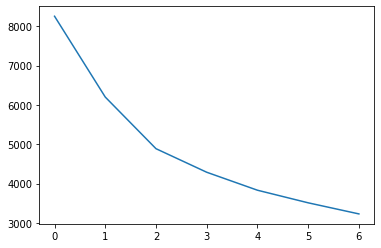

In [286]:
# 10.0 Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    _=kmeans.fit(rfm_df_scaled)
  
    ssd.append(kmeans.inertia_)
    
# 10.1 plot the SSDs for each n_clusters
_=plt.plot(ssd)

#### Silhoutte Score

In [287]:
# 10.2 Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    _=kmeans.fit(rfm_df_boxcox)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_boxcox, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.40630508591167747
For n_clusters=3, the silhouette score is 0.3380846572219491
For n_clusters=4, the silhouette score is 0.3270814661909782
For n_clusters=5, the silhouette score is 0.3055301437871313
For n_clusters=6, the silhouette score is 0.2982096735646919
For n_clusters=7, the silhouette score is 0.2956640331672624
For n_clusters=8, the silhouette score is 0.29083634586297186


#### Final model

In [289]:
# 10.3 Final model with k=3
#      Why 3? From domain knowledge, I think 3 would be OK.

kmeans = KMeans(n_clusters=3, max_iter=50)
_=kmeans.fit(rfm_df_scaled)

In [290]:
# 10.4 Assign cluster labels
rfm_df_scaled['Cluster_Id'] = kmeans.labels_
rfm_df_scaled.head()

revenue  frequency   recency  avg_unitprice  Cluster_Id
0  3.428523   1.326751 -0.612079      -0.439236           1
1  0.826498   0.199522 -0.173230       2.490367           0
2 -0.688310  -0.927706  2.692705       0.684575           2
3  0.083156  -0.927706  1.742427       1.306590           2
4 -0.558869  -0.927706  0.070495       1.025022           0

### Are clusters distinguishable cluster_ID wise

In [291]:
# 10.5.1 Draw boxplots
#sns.boxplot(x='Cluster_Id', y='revenue', data=rfm_df_scaled);
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="revenue")
fig.show()

In [292]:
# 10.5.2 Draw boxplots
#sns.boxplot(x='Cluster_Id', y='recency', data=rfm_aw);
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="recency")
fig.show()

In [293]:
# 10.5.3
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="frequency")
fig.show()
# sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_aw);

In [294]:
# 10.5.4
fig = px.box(rfm_df_scaled, x='Cluster_Id', y="avg_unitprice")
fig.show()
# sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_aw);

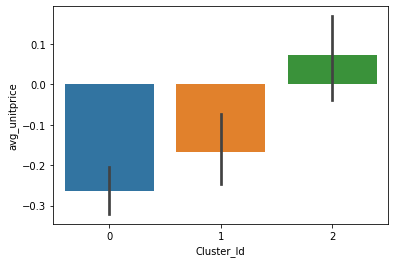

In [301]:
# 10.5.5 Are medians significantly different
#        If there is an overlap in error-bars, then no
#        Some medians are negative

ax=sns.barplot(data = rfm_df_scaled,
            x='Cluster_Id', 
            y="avg_unitprice",
            estimator = np.median)


### Gaussian Mixture Model

#### Perform boxcox again
Thistime with data without outliers

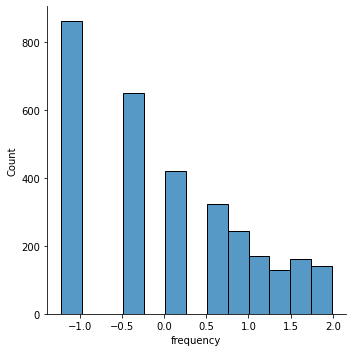

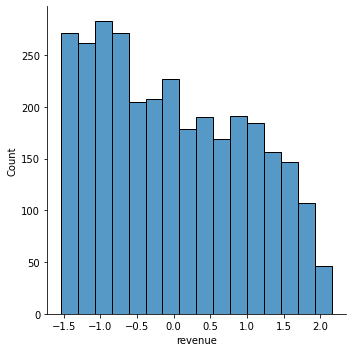

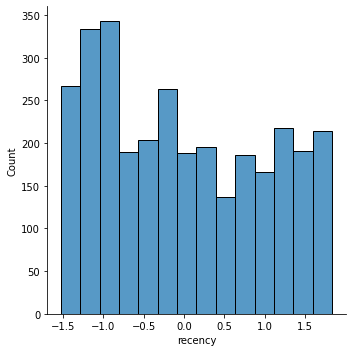

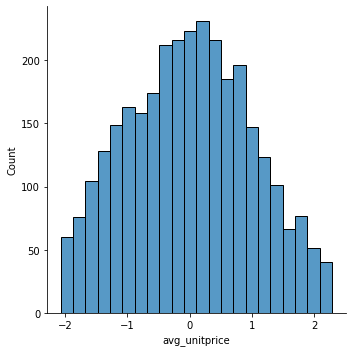

In [305]:
# 11.0 Boxcox transformation
from sklearn.preprocessing import power_transform

# 11.1
rfm_boxcox = power_transform(
                              rfm_df_scaled[cols1],
                              method = 'yeo-johnson'
                              )

# 11.2 PErform boxcox again
rfm_boxcox = pd.DataFrame(rfm_boxcox, columns=cols1)
_=sns.displot(rfm_boxcox, x = "frequency")
_=sns.displot(rfm_boxcox, x = "revenue")
_=sns.displot(rfm_boxcox, x = "recency")
_=sns.displot(rfm_boxcox, x = "avg_unitprice")

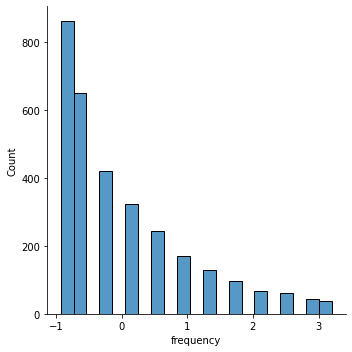

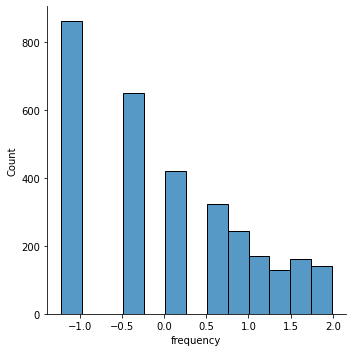

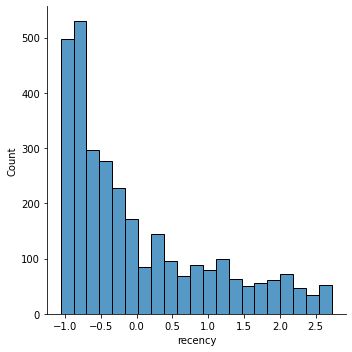

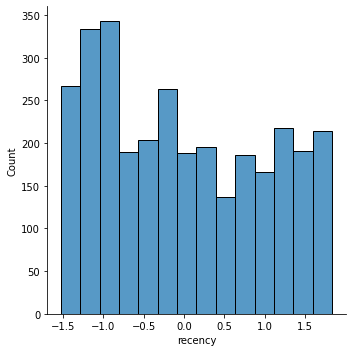

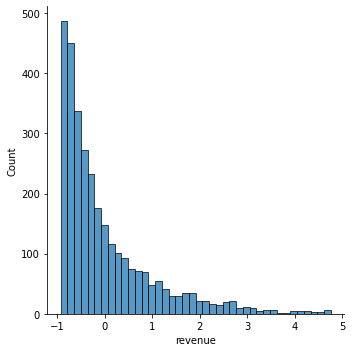

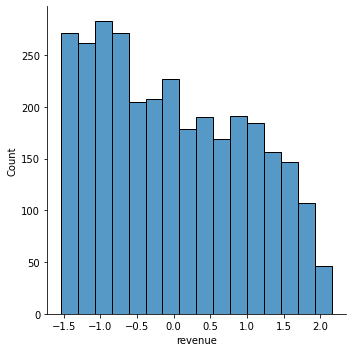

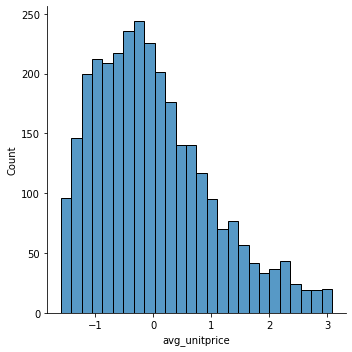

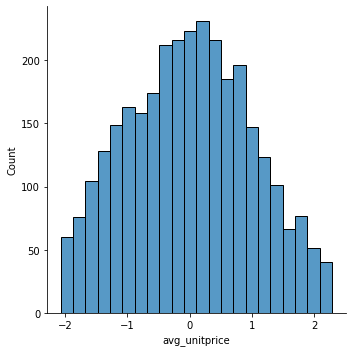

In [307]:
# 11.4
_=sns.displot(rfm_df_scaled, x = "frequency")
_=sns.displot(rfm_boxcox, x = "frequency")

# 11.5
print()
_=sns.displot(rfm_df_scaled, x = "recency")
_=sns.displot(rfm_boxcox, x = "recency")

# 11.6
print()
_=sns.displot(rfm_df_scaled, x = "revenue")
_=sns.displot(rfm_boxcox, x = "revenue")

# 11.7
print()
_=sns.displot(rfm_df_scaled, x = "avg_unitprice")
_=sns.displot(rfm_boxcox, x = "avg_unitprice")

In [335]:
# 12.0 Create a dataset
#      that mixes boxcox and scaled transformations

rfm_mix = rfm_df_scaled.copy()
rfm_mix['frequency']= rfm_boxcox['frequency']
rfm_mix['recency'] = rfm_boxcox['recency']
#rfm_mix['revenue'] = rfm_boxcox['revenue']
rfm_mix['avg_unitprice'] = rfm_boxcox['avg_unitprice']
rfm_mix.head()

revenue  frequency   recency  avg_unitprice
0  3.428523   1.337276 -0.541389      -0.324491
1  0.826498   0.584561  0.171261       1.978999
2 -0.688310  -1.230338  1.819134       0.808487
3  0.083156  -1.230338  1.503313       1.264340
4 -0.558869  -1.230338  0.464916       1.067217

In [ ]:
# 12.0 Import GaussianMixture class
from sklearn.mixture import GaussianMixture

# 12.1 Instantiate model
gm = GaussianMixture(
                     n_components = 3,
                     n_init = 30,
                     max_iter = 200)

# 12.2 Train the algorithm
cols = ['frequency', 'recency', 'revenue']

# 12.3
gm.fit(rfm_mix[cols])

# 12.4 Where are the clsuter centers
print("\n-----cluster means----\n")
gm.means_

# 12.5 Did algorithm converge?
print("\n-----Did it converge?----\n")
gm.converged_

# 12.6 How many iterations did it perform?
print("\n-----How many iteratons?----\n")
gm.n_iter_

In [345]:
# 13.0
silhouette_avg = silhouette_score(rfm_mix[cols], gm.predict(rfm_mix[cols]))
silhouette_avg

0.32076077374305717

In [346]:
# 13.1 Predict clusters labels
cid = gm.predict(rfm_mix[cols])

In [347]:
# 13.2
rfm_mix['cid'] = cid
rfm_mix.head()

revenue  frequency   recency  avg_unitprice  cid
0  3.428523   1.337276 -0.541389      -0.324491    0
1  0.826498   0.584561  0.171261       1.978999    0
2 -0.688310  -1.230338  1.819134       0.808487    1
3  0.083156  -1.230338  1.503313       1.264340    0
4 -0.558869  -1.230338  0.464916       1.067217    1

#### In each cluster, one feature is a distinguishing feature

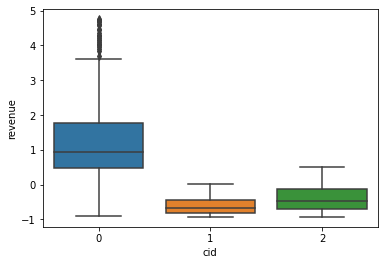

In [348]:
# 14.0
sns.boxplot(x='cid', y='revenue', data=rfm_mix);

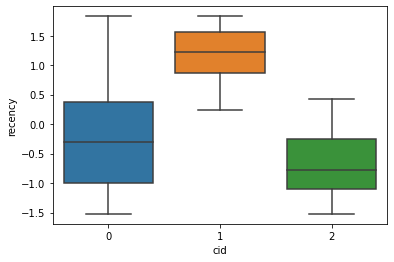

In [349]:
# 14.1
sns.boxplot(x='cid', y='recency', data=rfm_mix);

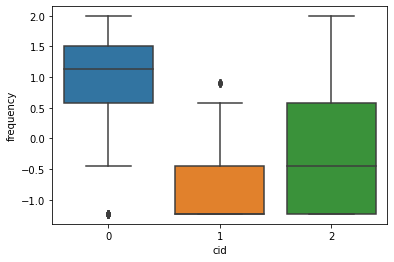

In [350]:
# 14.2
sns.boxplot(x='cid', y='frequency', data=rfm_mix);

> Cluster 1: High revenue + low recency + high frequency  

> Cluster 2: Low revenue + high recency + low frequency  

> Cluster 3: Low revenue + low recency + low frequency  


In [ ]:
############# I am done ###########

In [ ]:
bic = []
aic = []
cols = ['frequency', 'recency', 'revenue']
for i in range(10):
    print()
    print("No of clusters: ", i)
    print()
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 200,
                     init_params="kmeans")
    gm.fit(rfm_df_boxcox)
    bic.append(gm.bic(rfm_df_boxcox))
    aic.append(gm.aic(rfm_df_boxcox))

In [ ]:
bic = []
aic = []
cols = ['frequency', 'recency', 'revenue']
for i in range(50):
    print()
    print("No of clusters: ", i)
    print()
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100)
    gm.fit(rfm_df_scaled[cols])
    bic.append(gm.bic(rfm_df_scaled[cols]))
    aic.append(gm.aic(rfm_df_scaled[cols]))

In [240]:
str(5) + str("aa")

'5aa'

In [ ]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
bic = []
aic = []
lowest_bic = np.infty
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gm.fit(rfm_mix[cols])
        bic.append(cv_type + ":" +str(gm.bic(rfm_mix[cols])))
        aic.append(cv_type + ":" +str(gm.aic(rfm_mix[cols])))
        if gm.bic(rfm_mix[cols]) < lowest_bic:
            lowest_bic = gm.bic(rfm_mix[cols])
            best_gm = gm

In [ ]:
aic
print()
bic

In [133]:
rfm_mix.to_csv("rfm_mix.csv",index=False)

In [ ]:
####### I am done ##############